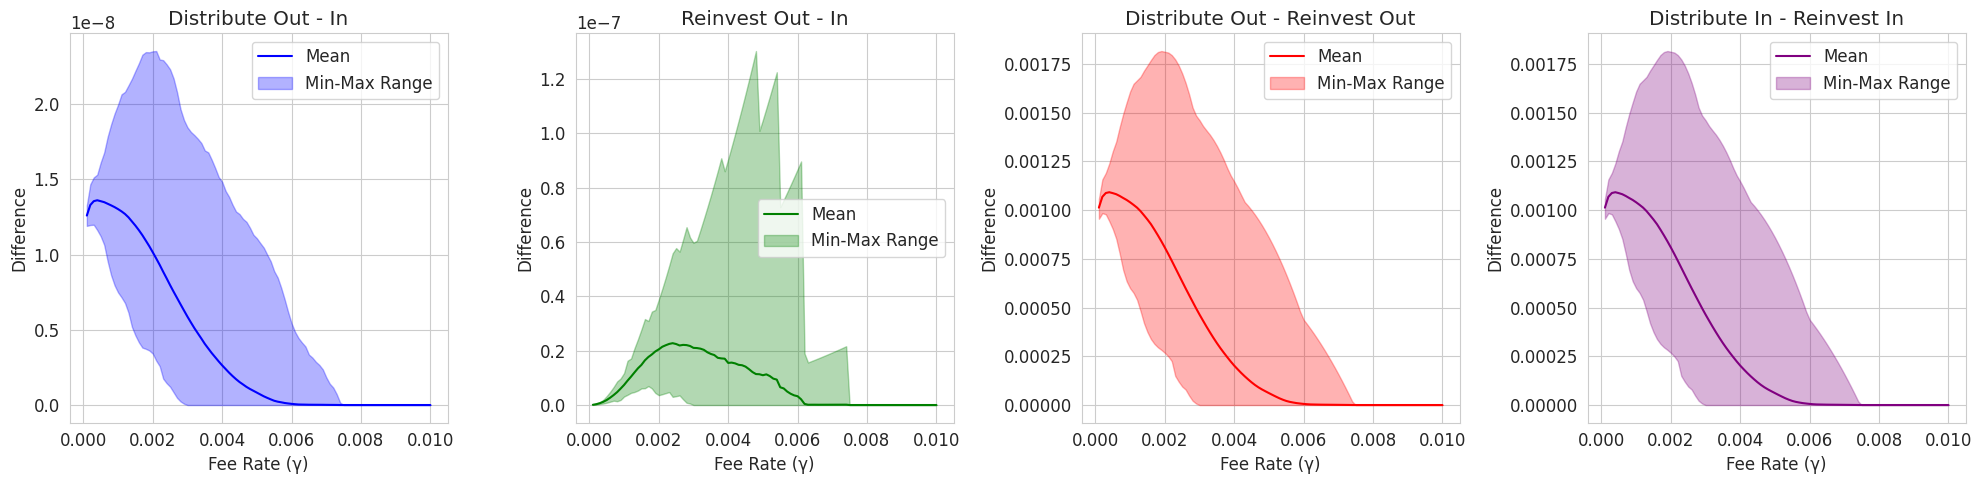

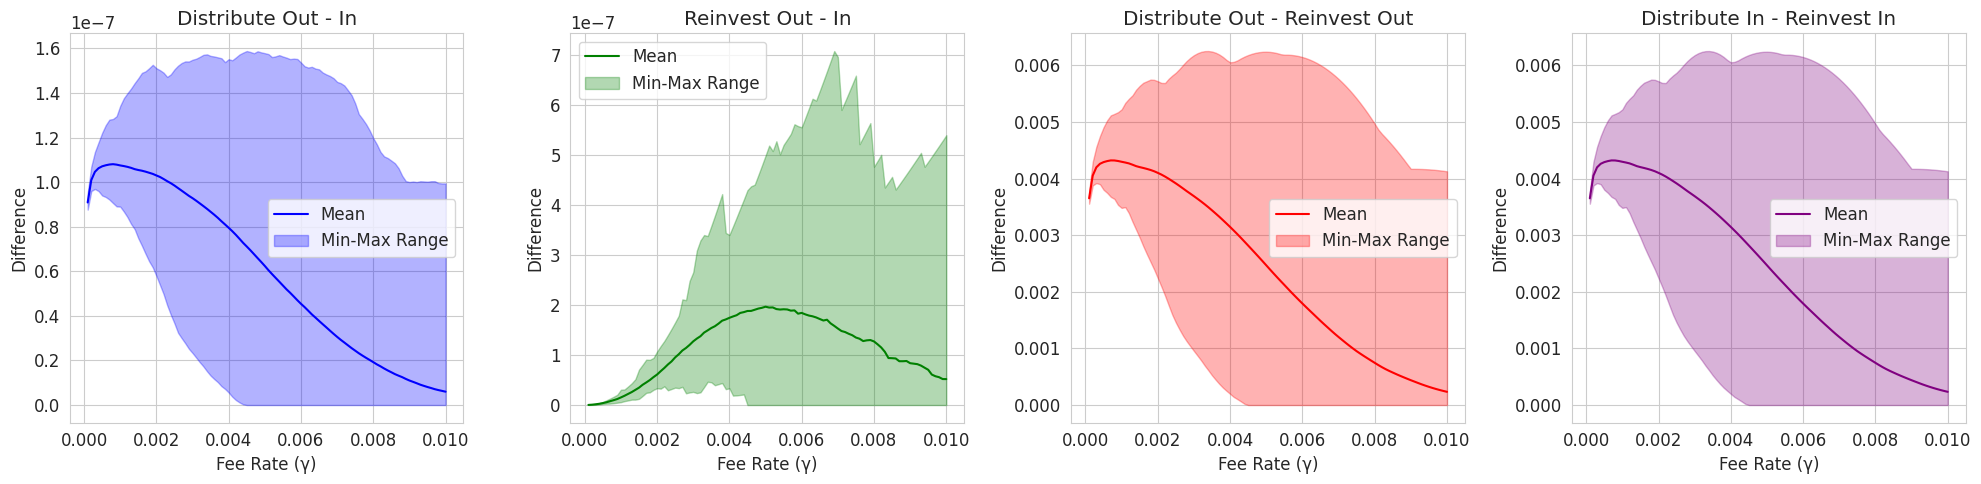

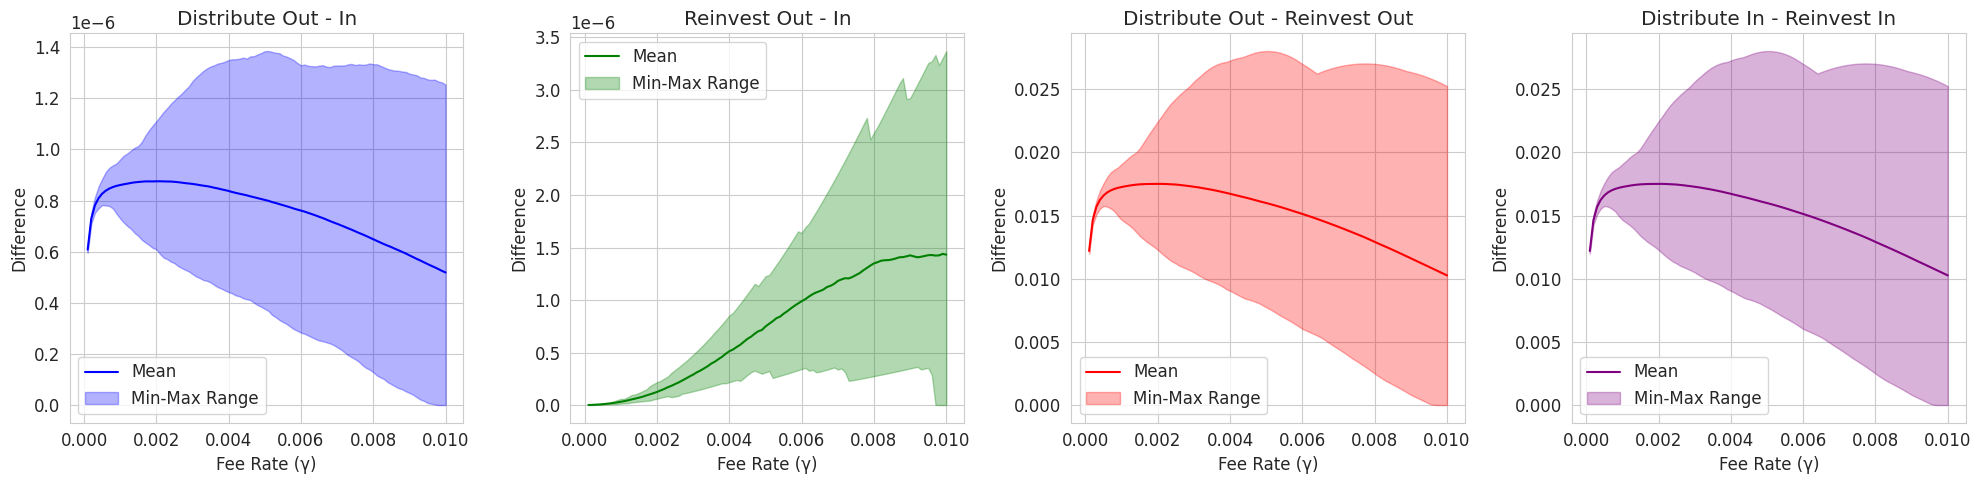

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def plot_differences(file_path, output_dir="plots"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Get sigma value from first row
    sigma = df.iloc[0]['sigma']
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Define metrics to plot
    metrics = [
        ('diff_dis_out_in', 'Distribute Out - In', 'blue', axes[0]),
        ('diff_re_out_in', 'Reinvest Out - In', 'green', axes[1]),
        ('diff_dis_out_re_out', 'Distribute Out - Reinvest Out', 'red', axes[2]),
        ('diff_dis_in_re_in', 'Distribute In - Reinvest In', 'purple', axes[3])
    ]
    
    # Process each metric
    for metric, title, color, ax in metrics:
        # If we have multiple runs (assuming the data includes multiple runs with same gamma values)
        # Group by gamma and compute statistics
        if len(df) > len(df['gamma'].unique()):
            # Group by gamma and calculate statistics
            grouped = df.groupby('gamma')[metric].agg(['mean', 'min', 'max']).reset_index()
            
            # Plot mean line
            ax.plot(grouped['gamma'], grouped['mean'], '-', color=color, label='Mean')
            
            # Plot min-max shaded area
            ax.fill_between(grouped['gamma'], grouped['min'], grouped['max'], 
                          alpha=0.3, color=color, label='Min-Max Range')
        else:
            # If we only have single values per gamma, just plot the line
            ax.plot(df['gamma'], df[metric], 'o-', color=color)
        
        ax.set_title(title)
        ax.set_xlabel('Fee Rate (γ)')
        ax.set_ylabel('Difference')
        ax.legend()
    
    # plt.suptitle(f'Value Differences vs Fee Rate (σ = {sigma})', fontsize=16)
    plt.tight_layout()
    # plt.subplots_adjust(top=0.88)
    plt.savefig(f"{output_dir}/individual_differences_sigma_{sigma}.png", dpi=500)


if __name__ == "__main__":
    # Path to your results file
    sigma = [0.002, 0.004, 0.008]
    for s in sigma:
        file_path = f"/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/results_{s}.csv"
        
        # Generate visualizations
        plot_differences(file_path)

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 12

def plot_difference_heatmaps(sigma_range, output_dir="plots"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Select 8 evenly spaced sigmas
    num_sigmas = 8
    sigma_positions = np.linspace(0, len(sigma_range)-1, num_sigmas, dtype=int)
    selected_sigmas = sigma_range[sigma_positions]
    
    # Initialize lists to store data for each metric
    metrics_data = {
        'diff_dis_out_in': [],
        'diff_re_out_in': [],
        'diff_dis_out_re_out': [],
        'diff_dis_in_re_in': []
    }
    
    # Collect data for selected sigma values
    for s in selected_sigmas:
        file_path = f"/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/results_{s}.csv"
        df = pd.read_csv(file_path)
        
        # Group by gamma and calculate mean for each metric
        grouped = df.groupby('gamma').mean().reset_index()
        
        for metric in metrics_data.keys():
            metrics_data[metric].append(grouped[metric].values)
    
    # Convert to numpy arrays
    for metric in metrics_data:
        metrics_data[metric] = np.array(metrics_data[metric])
    
    # Get unique gamma values
    gammas = grouped['gamma'].values
    
    # Select 8 evenly spaced gamma values
    num_ticks = 8
    tick_positions = np.linspace(0, len(gammas)-1, num_ticks, dtype=int)
    selected_gammas = gammas[tick_positions]
    
    # Convert to basis points (1 bp = 0.0001)
    selected_sigmas_bps = selected_sigmas * 10000
    selected_gammas_bps = selected_gammas * 10000
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Define metrics to plot
    metrics = [
        ('diff_dis_out_in', 'Distribute Out - In', axes[0, 0]),
        ('diff_re_out_in', 'Reinvest Out - In', axes[0, 1]),
        ('diff_dis_out_re_out', 'Distribute Out - Reinvest Out', axes[1, 0]),
        ('diff_dis_in_re_in', 'Distribute In - Reinvest In', axes[1, 1])
    ]
    
    # Process each metric
    for metric, title, ax in metrics:
        # Create heatmap with reversed data for correct sigma display
        sns.heatmap(metrics_data[metric][::-1], 
                   ax=ax,
                   cmap='coolwarm',
                   center=0,
                   cbar_kws={'label': 'Difference'})
        
        # Set custom x-axis ticks at evenly spaced positions
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{x:.0f}' for x in selected_gammas_bps])
        
        # Set y-axis labels (reversed to match the data)
        ax.set_yticklabels([f'{x:.0f}' for x in selected_sigmas_bps[::-1]])
        
        ax.set_title(title)
        ax.set_xlabel('Fee Rate (bps)')
        ax.set_ylabel('Volatility (bps)')
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Value Difference Heatmap', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f"{output_dir}/difference_heatmaps.png", dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    # Define sigma range
    sigma_range = np.round(np.arange(0.001, 0.021, 0.001), 3)
    
    # Generate heatmap visualizations
    plot_difference_heatmaps(sigma_range)

Observation:

1. Distribute strategy consistently outperforms reinvest strategy
2. Outgoing fee mechanism is superior to incoming fee mechanism
3. Both effects (distribute > reinvest, outgoing > incoming) are amplified by higher volatility and fee rates
4. The magnitude of difference between distribute and reinvest strategies is much larger than the difference between outgoing and incoming mechanisms

### Parquet Version

In [21]:
import polars as pl

path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/all_paths_results_0.001_combined.parquet'

df = pl.read_parquet(path)
print(df.columns)



['sigma', 'gamma', 'dis_inc_value', 'dis_inc_fee', 'dis_out_value', 'dis_out_fee', 're_inc_value', 're_out_value', 'diff_dis_out_in', 'diff_re_out_in', 'diff_dis_out_re_out', 'diff_dis_in_re_in']


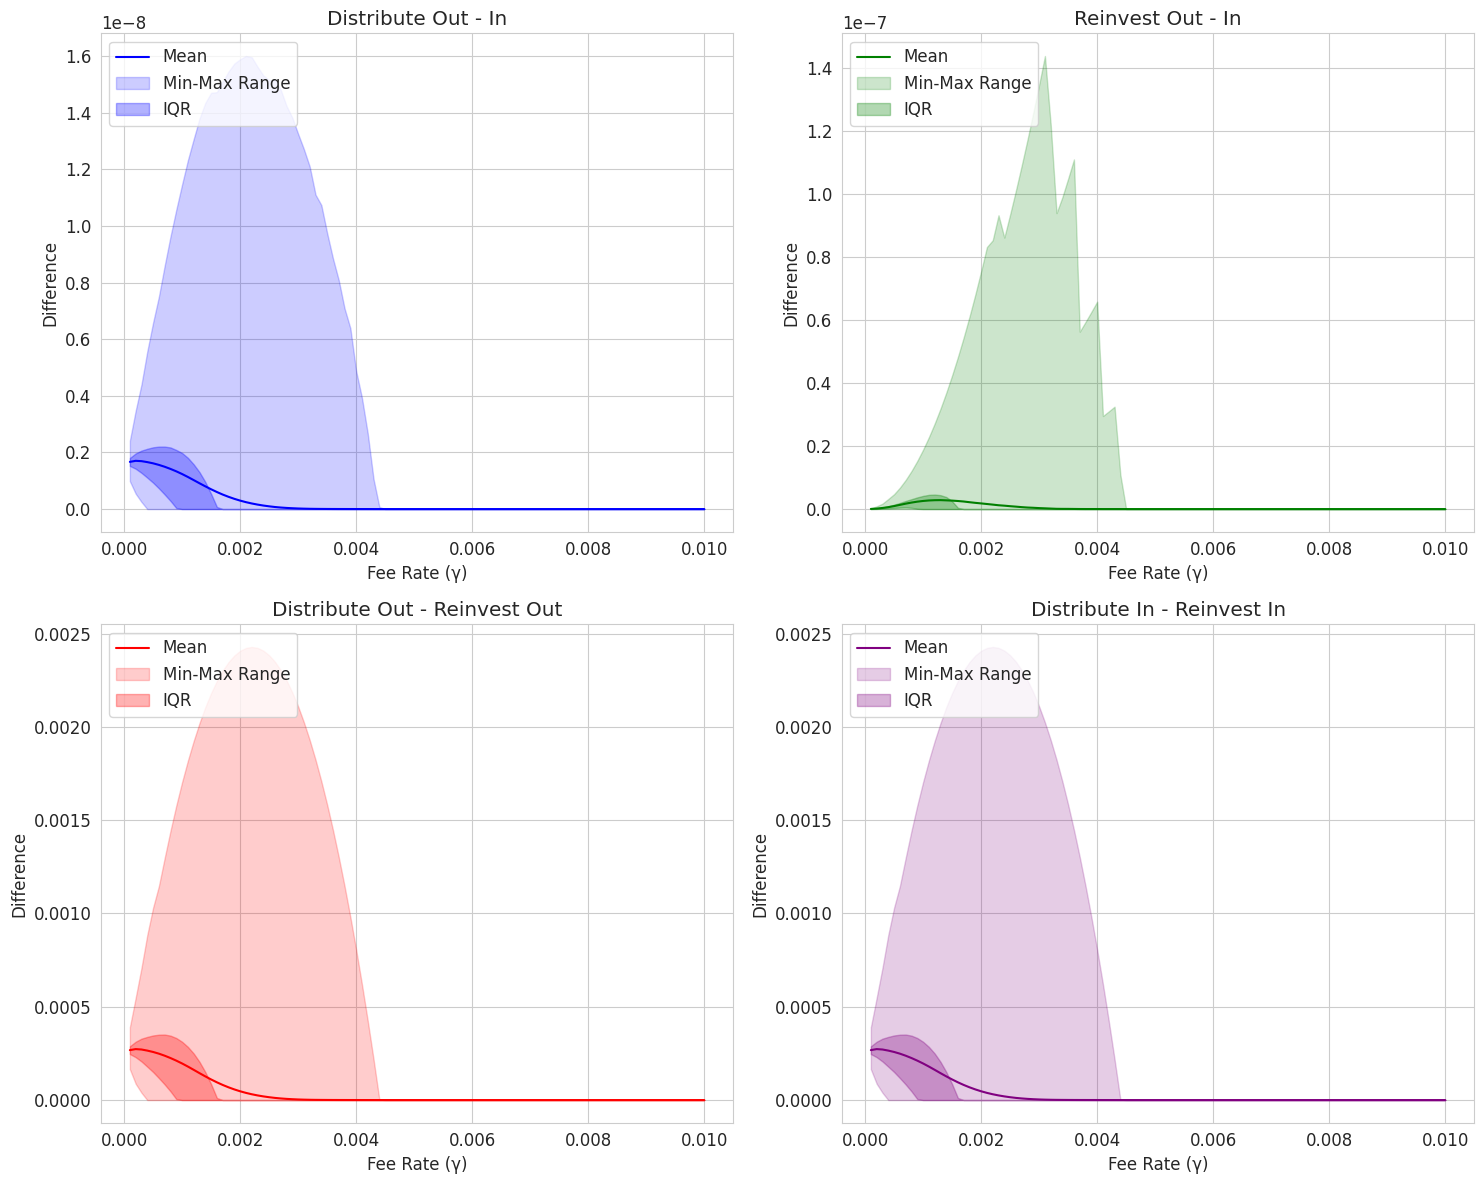

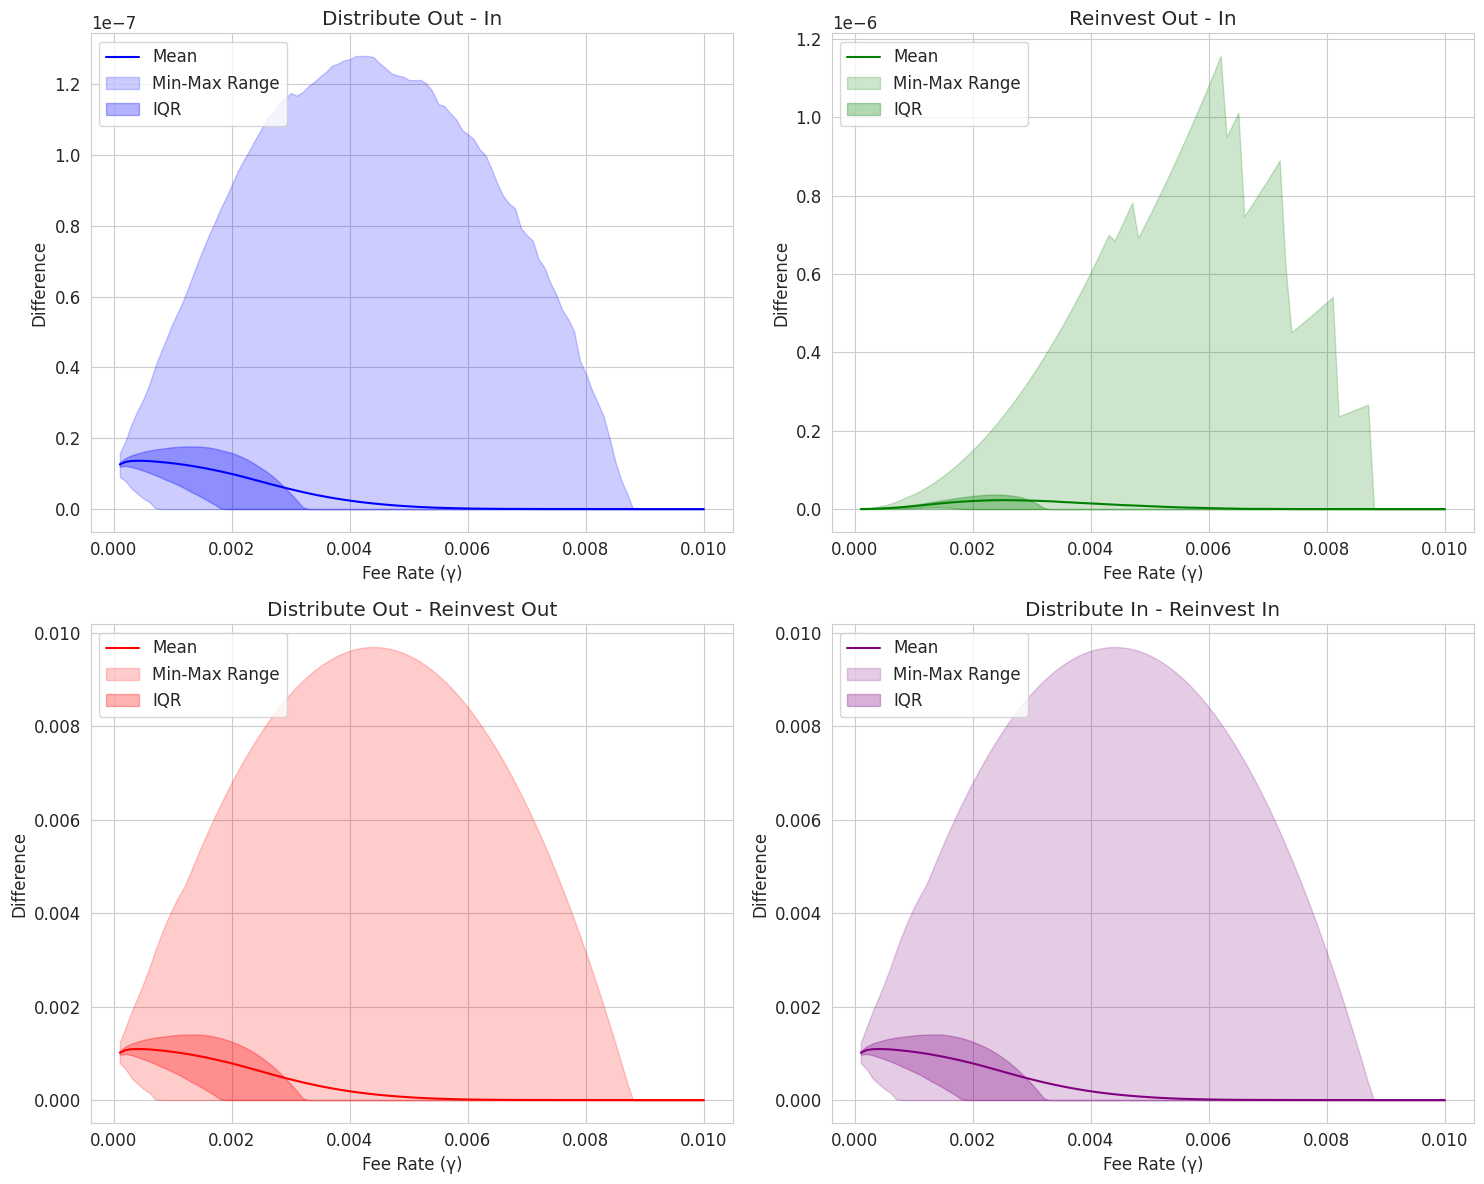

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import polars as pl

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 12

def plot_differences_parquet(file_path, output_dir="plots"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Read the parquet file
    df = pl.read_parquet(file_path)
    
    # Get sigma value from first row
    sigma = df['sigma'][0]
    
    # Create 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
    
    # Define metrics to plot
    metrics = [
        ('diff_dis_out_in', 'Distribute Out - In', 'blue', axes[0]),
        ('diff_re_out_in', 'Reinvest Out - In', 'green', axes[1]),
        ('diff_dis_out_re_out', 'Distribute Out - Reinvest Out', 'red', axes[2]),
        ('diff_dis_in_re_in', 'Distribute In - Reinvest In', 'purple', axes[3])
    ]
    
    # Process each metric
    for metric, title, color, ax in metrics:
        # Group by gamma and compute statistics
        grouped = df.group_by('gamma').agg([
            pl.col(metric).mean().alias('mean'),
            pl.col(metric).min().alias('min'),
            pl.col(metric).max().alias('max'),
            pl.col(metric).quantile(0.25).alias('q25'),
            pl.col(metric).quantile(0.75).alias('q75')
        ]).sort('gamma')
        
        # Convert to pandas for plotting
        grouped_pd = grouped.to_pandas()
        
        # Plot mean line
        ax.plot(grouped_pd['gamma'], grouped_pd['mean'], '-', color=color, label='Mean')
        
        # Plot min-max shaded area
        ax.fill_between(grouped_pd['gamma'], grouped_pd['min'], grouped_pd['max'], 
                      alpha=0.2, color=color, label='Min-Max Range')
        
        # Plot interquartile range
        ax.fill_between(grouped_pd['gamma'], grouped_pd['q25'], grouped_pd['q75'], 
                      alpha=0.3, color=color, label='IQR')
        
        ax.set_title(title)
        ax.set_xlabel('Fee Rate (γ)')
        ax.set_ylabel('Difference')
        ax.legend(loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/individual_differences_sigma_{sigma}.png", dpi=500, bbox_inches='tight')


if __name__ == "__main__":
    # Path to your parquet file
    sigma = [0.001, 0.002]  
    for s in sigma:
        file_path = f"/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/all_paths_results_{s}_combined.parquet"
        
        # Generate visualizations
        plot_differences_parquet(file_path)


In [35]:
import polars as pl

path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/all_paths_results_0.01_combined.parquet'

df = pl.read_parquet(path)

print(df.columns)

['sigma', 'gamma', 'dis_inc_value', 'dis_inc_fee', 'dis_out_value', 'dis_out_fee', 're_inc_value', 're_out_value', 'diff_dis_out_in', 'diff_re_out_in', 'diff_dis_out_re_out', 'diff_dis_in_re_in']


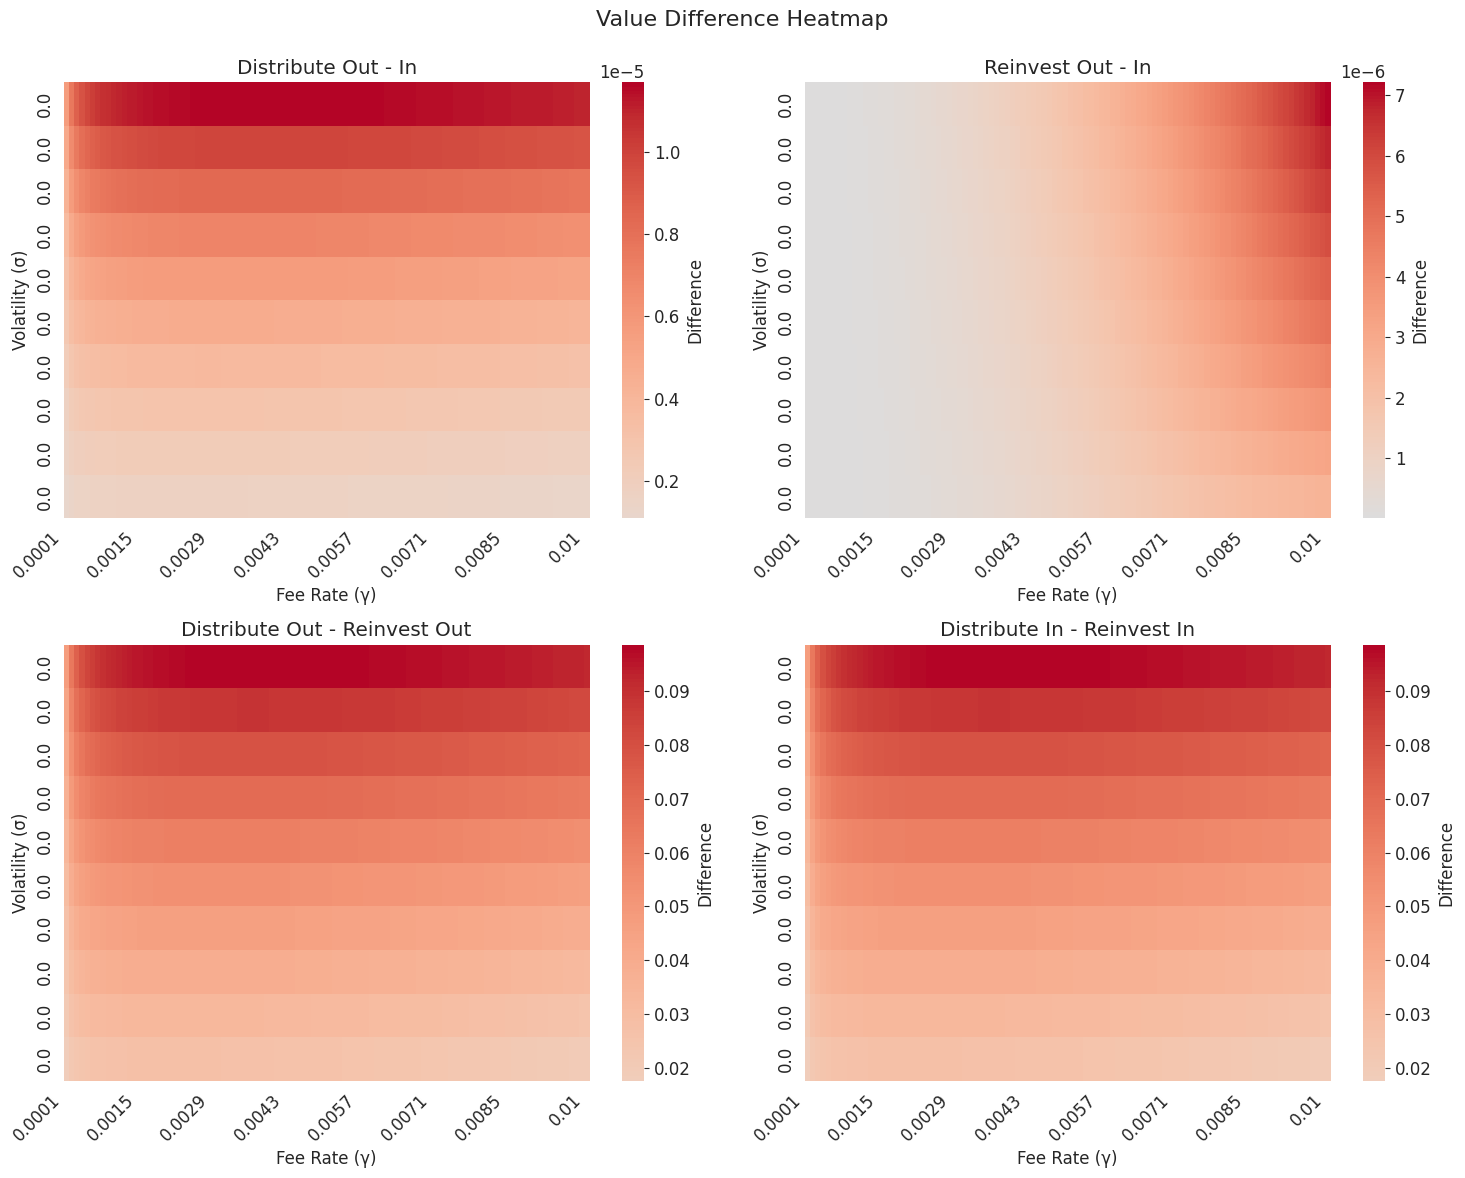

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 12

def plot_difference_heatmaps(output_dir="plots"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize lists to store data for each metric
    metrics_data = {
        'diff_dis_out_in': [],
        'diff_re_out_in': [],
        'diff_dis_out_re_out': [],
        'diff_dis_in_re_in': []
    }
    
    # Get all parquet files and sort them by sigma value
    base_path = "/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results"
    files = glob.glob(f"{base_path}/all_paths_results_*_combined.parquet")
    files.sort(key=lambda x: float(x.split('_')[-2]))  # Sort by sigma value
    
    # Store sigma values
    sigma_values = []
    first_file = True
    gammas = None
    
    # Process each file
    for file_path in files:
        # Extract sigma value from filename
        sigma = float(file_path.split('_')[-2])
        sigma_values.append(sigma)
        
        # Read the parquet file
        df = pd.read_parquet(file_path)
        
        # Group by gamma and calculate mean for each metric
        grouped = df.groupby('gamma').mean().reset_index()
        
        # Store gamma values from first file
        if first_file:
            gammas = grouped['gamma'].values
            first_file = False
        
        # Store data for each metric
        for metric in metrics_data.keys():
            metrics_data[metric].append(grouped[metric].values)
    
    # Convert to numpy arrays
    for metric in metrics_data:
        metrics_data[metric] = np.array(metrics_data[metric])
    
    # Create evenly spaced x-axis positions
    num_ticks = 8
    tick_positions = np.linspace(0, len(gammas)-1, num_ticks, dtype=int)
    selected_gammas = gammas[tick_positions]
    
    # Reverse sigma range for display (increasing from bottom to top)
    sigmas = sigma_values[::-1]
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Define metrics to plot
    metrics = [
        ('diff_dis_out_in', 'Distribute Out - In', axes[0, 0]),
        ('diff_re_out_in', 'Reinvest Out - In', axes[0, 1]),
        ('diff_dis_out_re_out', 'Distribute Out - Reinvest Out', axes[1, 0]),
        ('diff_dis_in_re_in', 'Distribute In - Reinvest In', axes[1, 1])
    ]
    
    # Process each metric
    for metric, title, ax in metrics:
        # Create heatmap with reversed data for correct sigma display
        sns.heatmap(metrics_data[metric][::-1], 
                   ax=ax,
                   cmap='coolwarm',
                   center=0,
                   cbar_kws={'label': 'Difference'})
        
        # Set custom x-axis ticks at evenly spaced positions
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(np.round(selected_gammas, 4))
        
        # Set y-axis labels
        ax.set_yticklabels(np.round(sigmas, 1))
        
        ax.set_title(title)
        ax.set_xlabel('Fee Rate (γ)')
        ax.set_ylabel('Volatility (σ)')
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Value Difference Heatmap', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f"{output_dir}/difference_heatmaps_all_sigma.png", dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    # Generate heatmap visualizations using all available files
    plot_difference_heatmaps()

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def process_file_for_mins(file_path):
    """Process a single file and extract only the minimum differences for each gamma."""
    sigma = float(file_path.split('_')[-2])
    
    # Read the file and immediately group by gamma to get minimums
    df = pd.read_parquet(file_path)
    
    # List of metrics we're interested in
    metrics = ['diff_dis_out_in', 'diff_re_out_in', 
              'diff_dis_out_re_out', 'diff_dis_in_re_in']
    
    # Group by gamma and get minimum for each metric
    min_df = df.groupby('gamma')[metrics].min().reset_index()
    
    # Add sigma column
    min_df['sigma'] = sigma
    
    return min_df

def plot_min_differences(output_dir="plots"):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all parquet files and sort them by sigma value
    base_path = "/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results"
    files = glob.glob(f"{base_path}/all_paths_results_*_combined.parquet")
    files.sort(key=lambda x: float(x.split('_')[-2]))
    
    # Process files one by one and collect minimal data
    min_dfs = []
    for file_path in files:
        print(f"Processing {file_path}")
        min_df = process_file_for_mins(file_path)
        min_dfs.append(min_df)
    
    # Combine all minimum data
    combined_df = pd.concat(min_dfs, ignore_index=True)
    
    # Create figure with shared colorbar
    fig, axes = plt.subplots(2, 2, figsize=(15, 14))
    
    # Define metrics to plot
    metrics = [
        ('diff_dis_out_in', 'Distribute Out - In', axes[0, 0]),
        ('diff_re_out_in', 'Reinvest Out - In', axes[0, 1]),
        ('diff_dis_out_re_out', 'Distribute Out - Reinvest Out', axes[1, 0]),
        ('diff_dis_in_re_in', 'Distribute In - Reinvest In', axes[1, 1])
    ]
    
    # Create colormap
    sigma_values = sorted(combined_df['sigma'].unique())
    norm = Normalize(vmin=min(sigma_values), vmax=max(sigma_values))
    cmap = plt.cm.viridis
    
    # Process each metric
    for metric, title, ax in metrics:
        for sigma in sigma_values:
            # Filter data for this sigma
            sigma_data = combined_df[combined_df['sigma'] == sigma]
            
            # Plot line with color based on sigma
            line = ax.plot(sigma_data['gamma'], sigma_data[metric], '-', 
                         color=cmap(norm(sigma)), 
                         label=f'σ={sigma}')
        
        ax.set_title(title)
        ax.set_xlabel('Fee Rate (γ)')
        ax.set_ylabel('Minimum Difference')
        ax.grid(True)
    
    # Adjust layout to make room for colorbar
    plt.tight_layout()
    
    # Add colorbar at the bottom
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
    sm = ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Volatility (σ)')
    
    # Adjust spacing
    plt.subplots_adjust(bottom=0.15)
    
    # Save the figure
    plt.savefig(f"{output_dir}/min_differences_lines.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Optionally, save the processed data for future use
    combined_df.to_parquet(f"{output_dir}/processed_min_differences.parquet")

if __name__ == "__main__":
    # Generate line plot visualizations
    plot_min_differences()

Processing /home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/all_paths_results_0.001_combined.parquet


KeyError: "Columns not found: 'diff_dis_out_in', 'diff_dis_in_re_in', 'diff_re_out_in', 'diff_dis_out_re_out'"

In [ ]:
import polars as pl

path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results_temp/all_paths_results_0.2_combined.parquet'

df = pl.read_parquet(path)

# print columns for df
print(df.columns)

In [ ]:
# calculate the mean of dis_inc_fee and dis_out_fee for each gamma and sort gamma
print(df.group_by('gamma').agg(pl.col('dis_inc_fee').mean(), pl.col('dis_out_fee').mean()).sort('gamma').to_pandas())



In [ ]:
import numpy as np
from scipy.stats import norm
import pandas as pd
x = 1000
y = 1000
L = 1000
p = 1
sigma = 0.2
delta_t = 1/(365*24)

def calculate_fee(p, gamma, L, sigma, delta_t):
    alpha = L * np.sqrt((1-gamma) * p * np.exp(-0.25 * sigma**2 * delta_t))
    d1 = np.log((1-gamma)*y/(p*x))/(sigma*np.sqrt(delta_t))
    d2 = np.log(y/((1-gamma)*p*x))/(sigma*np.sqrt(delta_t))
    d1_plus = d1 + 0.5*sigma*np.sqrt(delta_t)
    d1_minus = d1 - 0.5*sigma*np.sqrt(delta_t)
    d2_plus = d2 + 0.5*sigma*np.sqrt(delta_t)
    d2_minus = d2 - 0.5*sigma*np.sqrt(delta_t)
    inc_fee = (gamma / (1-gamma)) * (alpha * (norm.cdf(d1) + norm.cdf(-d2)) - p*x*norm.cdf(d1_minus) - y*norm.cdf(-d2_plus))
    out_fee = gamma * (-alpha * (norm.cdf(d1) + norm.cdf(-d2)) + p*x*norm.cdf(-d2_minus) + y*norm.cdf(d1_plus))
    return inc_fee, out_fee

results = []
for gamma in np.round(np.arange(0.0005, 0.0055, 0.0005), 4):
    inc_fee, out_fee = calculate_fee(p, gamma, L, sigma, delta_t)
    results.append({'gamma': gamma, 'inc_fee': inc_fee, 'out_fee': out_fee})

results_df = pd.DataFrame(results)
print(results_df.to_markdown())



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


path = '/home/shiftpub/Dynamic_AMM/fee_grid_results.csv'
df = pd.read_csv(path)
df.loc[:,'Vin'] = df.loc[:,'incoming_fee'] + df.loc[:,'pool_value']
df.loc[:,'Vout'] = df.loc[:,'outgoing_fee'] + df.loc[:,'pool_value']

# count how many rows have Vin - 2000 > 1e-6, and Vout - 2000 > 1e-6
print(len(df[df['Vin'] - 2000 > 1e-6]))
print(len(df[df['Vout'] - 2000 > 1e-6]))

# print where Vin - 2000 > 1e-6
# print(df[df['Vout'] - 2000 > 1e-6].to_markdown())

# print(df.head())




### Single Step Visualization

In [ ]:
# Create visualization with 3 subplots
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the data
path = '/home/shiftpub/Dynamic_AMM/fee_grid_results.csv'
df = pd.read_csv(path)

# Create figure with 3 subplots and extra space at bottom for legend
fig = plt.figure(figsize=(15, 5))  # Increased height to accommodate legend
gs = fig.add_gridspec(2, 2, height_ratios=[12, 1])  # Added hspace for vertical spacing
axes = [fig.add_subplot(gs[0, i]) for i in range(2)]
sigma_values = [1.0, 2.0]

# Create legend handles and labels
legend_handles = []
legend_labels = []

for idx, sigma in enumerate(sigma_values):
    ax = axes[idx]
    ax2 = ax.twinx()  # Create second y-axis
    
    # Filter data for current sigma
    df_sigma = df[df['sigma'] == sigma]
    
    # Calculate values
    incoming_value = df_sigma['pool_value'] + df_sigma['incoming_fee']
    outgoing_value = df_sigma['pool_value'] + df_sigma['outgoing_fee']
    difference = outgoing_value - incoming_value
    
    # Plot lines
    line1, = ax.plot(df_sigma['gamma'], incoming_value, 'b-', label='Incoming Value')
    line2, = ax.plot(df_sigma['gamma'], outgoing_value, 'r-', label='Outgoing Value')
    
    # Plot difference as shaded area
    diff_fill = ax2.fill_between(df_sigma['gamma'], difference, alpha=0.3, color='green', label='Difference')
    
    # Customize plot
    ax.set_title(f'σ = {sigma}')
    ax.set_xlabel('Fee Rate (γ)')
    if idx == 0:
        ax.set_ylabel('Value')
    if idx == 1:
        ax2.set_ylabel('Difference (Outgoing - Incoming)')
    
    # Store handles and labels for shared legend
    if idx == 0:  # Only add once
        legend_handles.extend([line1, line2, diff_fill])
        legend_labels.extend(['Incoming Value', 'Outgoing Value', 'Difference (Outgoing - Incoming)'])

# Create shared legend at the bottom
legend_ax = fig.add_subplot(gs[1, :])
legend_ax.axis('off')
legend = legend_ax.legend(legend_handles, legend_labels, 
                         loc='center', ncol=3, bbox_to_anchor=(0.5, 0.6))

# Remove tight_layout and use only subplots_adjust
plt.tight_layout()

plt.savefig('fee_analysis.png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
# Create visualization with 3x3 subplots
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the data
path = '/home/shiftpub/Dynamic_AMM/fee_grid_results.csv'
df = pd.read_csv(path)

# Create figure with 3x3 subplots and extra space at bottom for legend
fig = plt.figure(figsize=(15, 15))  # Increased size for 3x3 grid
gs = fig.add_gridspec(4, 3, height_ratios=[5, 5, 5, 1])  # 3x3 grid plus space for legend
axes = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(3)]
sigma_values = [0.2, 0.4, 0.6, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

# Create legend handles and labels
legend_handles = []
legend_labels = []

for idx, sigma in enumerate(sigma_values):
    row = idx // 3
    col = idx % 3
    ax = axes[row][col]
    ax2 = ax.twinx()  # Create second y-axis
    
    # Filter data for current sigma
    df_sigma = df[df['sigma'] == sigma]
    
    # Calculate values
    incoming_value = df_sigma['pool_value'] + df_sigma['incoming_fee'] - 2000
    outgoing_value = df_sigma['pool_value'] + df_sigma['outgoing_fee'] - 2000
    difference = outgoing_value - incoming_value
    
    # Plot lines
    line1, = ax.plot(df_sigma['gamma'], incoming_value, 'b-', label='Incoming Value')
    line2, = ax.plot(df_sigma['gamma'], outgoing_value, 'r-', label='Outgoing Value')
    
    # Plot difference as grey shaded area
    diff_fill = ax2.fill_between(df_sigma['gamma'], difference, alpha=0.3, color='grey', label='Difference')
    
    # Customize plot
    ax.set_title(f'σ = {sigma}')
    ax.set_xlabel('Fee Rate (γ)')
    if row == 2 and col == 0:  # Only show labels for bottom-left plot
        ax.set_ylabel('LP Revenue')
        ax2.set_ylabel('Difference (Outgoing - Incoming)')
    
    # Store handles and labels for shared legend
    if idx == 0:  # Only add once
        legend_handles.extend([line1, line2, diff_fill])
        legend_labels.extend(['Incoming Value', 'Outgoing Value', 'Difference'])

# Create shared legend at the bottom
legend_ax = fig.add_subplot(gs[3, :])
legend_ax.axis('off')
legend = legend_ax.legend(legend_handles, legend_labels, 
                         loc='center', ncol=3, bbox_to_anchor=(0.5, 0.6))

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('fee_analysis_3x3.png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np

0.008* np.sqrt(1/(1/(365 * 24)))

In [38]:
import polars as pl

path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results_temp/all_paths_results_0.006_combined.parquet'

df = pl.read_parquet(path)

path_idx = 0
seed_idx = 0
gamma = 0.005

selected_df = df.filter(pl.col('path_idx') == path_idx, pl.col('seed_idx') == seed_idx, pl.col('gamma') == gamma)

print(selected_df.head())

# write to csv
selected_df.write_csv('selected_df.csv')


shape: (5, 13)
┌──────────┬──────────┬──────────┬───────┬───┬──────────┬──────────┬──────────┬──────────┐
│ seed_idx ┆ path_idx ┆ time_idx ┆ gamma ┆ … ┆ re_inc_x ┆ re_inc_y ┆ re_out_x ┆ re_out_y │
│ ---      ┆ ---      ┆ ---      ┆ ---   ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i64      ┆ i64      ┆ i64      ┆ f64   ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪═══════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 0        ┆ 0        ┆ 0        ┆ 0.005 ┆ … ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   │
│ 0        ┆ 0        ┆ 1        ┆ 0.005 ┆ … ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   │
│ 0        ┆ 0        ┆ 2        ┆ 0.005 ┆ … ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   │
│ 0        ┆ 0        ┆ 3        ┆ 0.005 ┆ … ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   │
│ 0        ┆ 0        ┆ 4        ┆ 0.005 ┆ … ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   ┆ 1000.0   │
└──────────┴──────────┴──────────┴───────┴───┴──────────┴──────────┴───────

In [42]:
import numpy as np
import pandas as pd

path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/selected_df.csv'
df = pd.read_csv(path)

print(df.columns)

Index(['seed_idx', 'path_idx', 'time_idx', 'gamma', 'price', 'dis_x', 'dis_y',
       'dis_inc_fees', 'dis_out_fees', 're_inc_x', 're_inc_y', 're_out_x',
       're_out_y'],
      dtype='object')


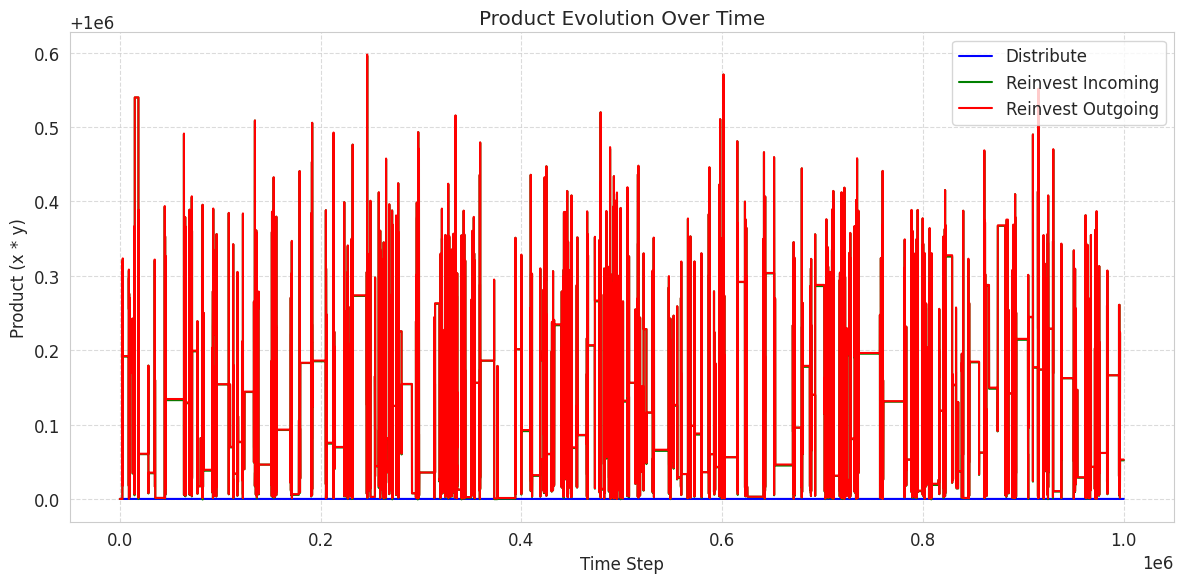

In [44]:

# Create visualization for product over time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create figure
plt.figure(figsize=(12, 6))

# Calculate products for different scenarios
df['dis_product'] = df['dis_x'] * df['dis_y']
df['re_inc_product'] = df['re_inc_x'] * df['re_inc_y']
df['re_out_product'] = df['re_out_x'] * df['re_out_y']

df.to_csv('new_selected_df.csv', index=False)

# Plot products over time for different scenarios
plt.plot(df['time_idx'], df['dis_product'], label='Distribute', color='blue')
plt.plot(df['time_idx'], df['re_inc_product'], label='Reinvest Incoming', color='green')
plt.plot(df['time_idx'], df['re_out_product'], label='Reinvest Outgoing', color='red')

# Customize plot
plt.xlabel('Time Step')
plt.ylabel('Product (x * y)')
plt.title('Product Evolution Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import os
import glob

# Path to the directory containing the CSV files
input_dir = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results'
output_file = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/combined_results.csv'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(input_dir, 'results_sigma*.csv'))

# Sort the files to ensure consistent order
csv_files.sort()

print(f"Found {len(csv_files)} CSV files to combine")

# Initialize an empty list to store dataframes
dfs = []

# Read each CSV file and append to the list
for file in csv_files:
    print(f"Reading {file}")
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes
print("Concatenating all dataframes...")
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined dataframe to a new CSV file
print(f"Saving combined data to {output_file}")
combined_df.to_csv(output_file, index=False)

print(f"Combined {len(csv_files)} files into {output_file}")
print(f"Total rows in combined file: {len(combined_df)}")

combined_df = pd.read_csv('/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/combined_results.csv')
# Read the combined results
print(combined_df.columns)

Found 5 CSV files to combine
Reading /home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/results_sigma0.001.csv
Reading /home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/results_sigma0.002.csv
Reading /home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/results_sigma0.003.csv
Reading /home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/results_sigma0.004.csv
Reading /home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/results_sigma0.005.csv
Concatenating all dataframes...
Saving combined data to /home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/combined_results.csv
Combined 5 files into /home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/combined_results.csv
Total rows in combined file: 500000
Index(['seed', 'sigma', 'gamma', 'path_idx', 'S_T', 'dis_x', 'dis_y',
       're_inc_x', 're_inc_y', 're_out_x', 're_out_y', 'dis_inc_fee',
       'dis_out_fee', 'dis_vin', 'dis_vout', 're_vin', 're_vout'],
      dtype='object')


   seed  sigma  gamma  path_idx   dis_x   dis_y  re_inc_x  re_inc_y  re_out_x  \
0     0  0.001  0.003         0  1000.0  1000.0    1000.0    1000.0    1000.0   
1     0  0.001  0.003         1  1000.0  1000.0    1000.0    1000.0    1000.0   
2     0  0.001  0.003         2  1000.0  1000.0    1000.0    1000.0    1000.0   
3     0  0.001  0.003         3  1000.0  1000.0    1000.0    1000.0    1000.0   
4     0  0.001  0.003         4  1000.0  1000.0    1000.0    1000.0    1000.0   

   re_out_y  dis_inc_fee  dis_out_fee  
0    1000.0          0.0          0.0  
1    1000.0          0.0          0.0  
2    1000.0          0.0          0.0  
3    1000.0          0.0          0.0  
4    1000.0          0.0          0.0  


/tmp/ipykernel_2942364/1287893602.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data1, labels=[f'σ = {sigma:.3f}' for sigma in sigmas])
/tmp/ipykernel_2942364/1287893602.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data2, labels=[f'σ = {sigma:.3f}' for sigma in sigmas])
/tmp/ipykernel_2942364/1287893602.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(data3, labels=[f'σ = {sigma:.3f}' for sigma in sigmas])
/tmp/ipykernel_2942364/1287893602.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; 

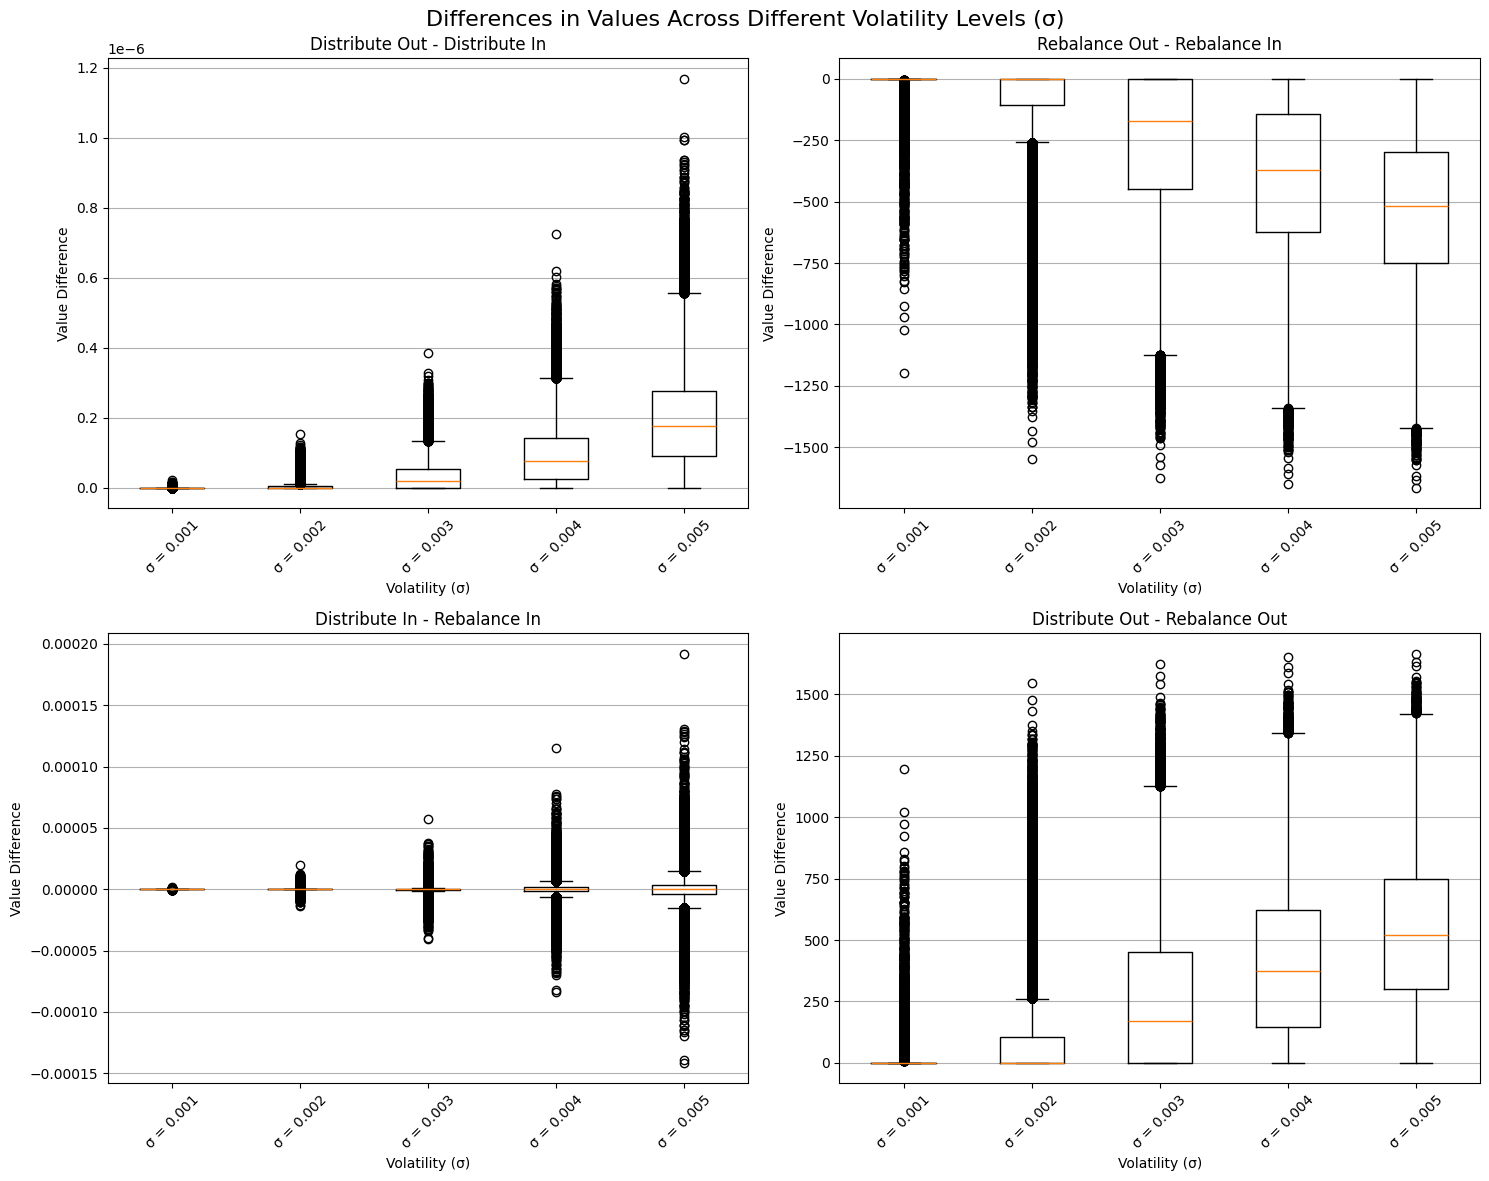

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_differences(df):
    """
    Create a figure with four subplots showing boxplots of differences between various values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the simulation results with columns:
        ['seed', 'sigma', 'gamma', 'path_idx', 'S_T', 'dis_x', 'dis_y',
         're_inc_x', 're_inc_y', 're_out_x', 're_out_y', 'dis_inc_fee',
         'dis_out_fee', 'dis_vin', 'dis_vout', 're_vin', 're_vout']
    """
    # Create figure with four subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Differences in Values Across Different Volatility Levels (σ)', fontsize=16)
    
    # Get unique sigma values
    sigmas = sorted(df['sigma'].unique())
    
    # Plot 1: Distribute Out - Distribute In
    ax1 = axes[0, 0]
    data1 = [df[df['sigma'] == sigma]['dis_vout'] - df[df['sigma'] == sigma]['dis_vin'] for sigma in sigmas]
    ax1.boxplot(data1, labels=[f'σ = {sigma:.3f}' for sigma in sigmas])
    ax1.set_title('Distribute Out - Distribute In')
    ax1.set_xlabel('Volatility (σ)')
    ax1.set_ylabel('Value Difference')
    ax1.grid(True, axis='y')
    plt.setp(ax1.get_xticklabels(), rotation=45)
    
    # Plot 2: Rebalance Out - Rebalance In
    ax2 = axes[0, 1]
    data2 = [df[df['sigma'] == sigma]['re_vout'] - df[df['sigma'] == sigma]['re_vin'] for sigma in sigmas]
    ax2.boxplot(data2, labels=[f'σ = {sigma:.3f}' for sigma in sigmas])
    ax2.set_title('Rebalance Out - Rebalance In')
    ax2.set_xlabel('Volatility (σ)')
    ax2.set_ylabel('Value Difference')
    ax2.grid(True, axis='y')
    plt.setp(ax2.get_xticklabels(), rotation=45)
    
    # Plot 3: Distribute In - Rebalance In
    ax3 = axes[1, 0]
    data3 = [df[df['sigma'] == sigma]['dis_vin'] - df[df['sigma'] == sigma]['re_vin'] for sigma in sigmas]
    ax3.boxplot(data3, labels=[f'σ = {sigma:.3f}' for sigma in sigmas])
    ax3.set_title('Distribute In - Rebalance In')
    ax3.set_xlabel('Volatility (σ)')
    ax3.set_ylabel('Value Difference')
    ax3.grid(True, axis='y')
    plt.setp(ax3.get_xticklabels(), rotation=45)
    
    # Plot 4: Distribute Out - Rebalance Out
    ax4 = axes[1, 1]
    data4 = [df[df['sigma'] == sigma]['dis_vout'] - df[df['sigma'] == sigma]['re_vout'] for sigma in sigmas]
    ax4.boxplot(data4, labels=[f'σ = {sigma:.3f}' for sigma in sigmas])
    ax4.set_title('Distribute Out - Rebalance Out')
    ax4.set_xlabel('Volatility (σ)')
    ax4.set_ylabel('Value Difference')
    ax4.grid(True, axis='y')
    plt.setp(ax4.get_xticklabels(), rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig


if __name__ == "__main__":
    df = pd.read_csv('/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/combined_results.csv')
    fig = plot_differences(df)
    fig.show()

In [1]:
import pandas as pd

path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/mc_results/results_sigma0.006.csv'
df = pd.read_csv(path)

print(df.head(10).to_markdown())


|    |   seed |   sigma |   gamma |   path_idx |      S_T |    dis_x |    dis_y |   re_inc_x |   re_inc_y |   re_out_x |   re_out_y |   dis_inc_fee |   dis_out_fee |   dis_vin |   dis_vout |   re_vin |   re_vout |
|---:|-------:|--------:|--------:|-----------:|---------:|---------:|---------:|-----------:|-----------:|-----------:|-----------:|--------------:|--------------:|----------:|-----------:|---------:|----------:|
|  0 |      0 |   0.006 |   0.003 |          0 | 1.00403  |  998.739 | 1001.26  |    998.747 |   1001.27  |    493.491 |    494.738 |    0.0163203  |    0.0163209  |   2004.05 |    2004.05 |  2004.05 |   990.219 |
|  1 |      0 |   0.006 |   0.003 |          1 | 1.00194  |  998.221 | 1001.78  |    998.223 |   1001.79  |    801.895 |    804.756 |    0.00536338 |    0.0053636  |   2001.94 |    2001.94 |  2001.94 |  1608.21  |
|  2 |      0 |   0.006 |   0.003 |          2 | 1.00172  |  999.048 | 1000.95  |    999.051 |   1000.96  |    755.823 |    757.263 |    0.00550